In [15]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from time import perf_counter 
import os
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from tensorflow.keras.utils import plot_model

In [16]:
## Defining batch specfications
batch_size = 30
img_height = 250
img_width = 250

In [17]:
## loading training set
training_data = tf.keras.preprocessing.image_dataset_from_directory(
    'data/train',
    seed=42,
    image_size= (img_height, img_width),
    batch_size=batch_size,
    color_mode='rgb'
)

Found 281 files belonging to 2 classes.


In [20]:
## loading validation dataset
validation_data =  tf.keras.preprocessing.image_dataset_from_directory(
    'data/val',
    seed=42,
    image_size= (img_height, img_width),
    batch_size=batch_size,
    color_mode='rgb'
)

Found 281 files belonging to 2 classes.


In [21]:
## loading testing dataset
testing_data = tf.keras.preprocessing.image_dataset_from_directory(
    'data/test',
    seed=42,
    image_size= (img_height, img_width),
    batch_size=batch_size,
    color_mode='rgb'
)

Found 281 files belonging to 2 classes.


In [22]:
testing_data

<_BatchDataset element_spec=(TensorSpec(shape=(None, 250, 250, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [23]:
class_names = training_data.class_names
class_names

['Accident', 'Non Accident']

In [24]:
## Configuring dataset for performance
AUTOTUNE = tf.data.experimental.AUTOTUNE
training_data = training_data.cache().prefetch(buffer_size=AUTOTUNE)
testing_data = testing_data.cache().prefetch(buffer_size=AUTOTUNE)

In [25]:
## Defining Cnn
model = tf.keras.models.Sequential([
  layers.BatchNormalization(),
  layers.Conv2D(32, 3, activation='relu'), # Conv2D(f_size, filter_size, activation) # relu, sigmoid, softmax
  layers.MaxPooling2D(), # MaxPooling
  layers.Conv2D(64, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(256, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(512, activation='relu'),
  layers.Dense(len(class_names), activation= 'softmax')
])

model.compile(optimizer='adam',loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [26]:
model.build((None, 250, 250, 3))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_1 (Bat  (None, 250, 250, 3)       12        
 chNormalization)                                                
                                                                 
 conv2d_4 (Conv2D)           (None, 248, 248, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 124, 124, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 122, 122, 64)      18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 61, 61, 64)        0         
 g2D)                                                            
                                                      

In [27]:
plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [28]:
## lets train our CNN
checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
history = model.fit(training_data, validation_data=validation_data, epochs = 10, callbacks=callbacks_list)

Epoch 1/10
10/10 [==============================] - ETA: 0s - loss: 2.4418 - accuracy: 0.5196
Epoch 1: val_accuracy improved from -inf to 0.50890, saving model to model_weights.h5
10/10 [==============================] - 27s 2s/step - loss: 2.4418 - accuracy: 0.5196 - val_loss: 0.9171 - val_accuracy: 0.5089
Epoch 2/10
10/10 [==============================] - ETA: 0s - loss: 0.6828 - accuracy: 0.5196
Epoch 2: val_accuracy did not improve from 0.50890
10/10 [==============================] - 24s 2s/step - loss: 0.6828 - accuracy: 0.5196 - val_loss: 0.6856 - val_accuracy: 0.5089
Epoch 3/10
10/10 [==============================] - ETA: 0s - loss: 0.6517 - accuracy: 0.6085
Epoch 3: val_accuracy improved from 0.50890 to 0.53025, saving model to model_weights.h5
10/10 [==============================] - 27s 3s/step - loss: 0.6517 - accuracy: 0.6085 - val_loss: 1.3295 - val_accuracy: 0.5302
Epoch 4/10
10/10 [==============================] - ETA: 0s - loss: 0.5885 - accuracy: 0.6619
Epoch 4: va

In [30]:
###### serialize model structure to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

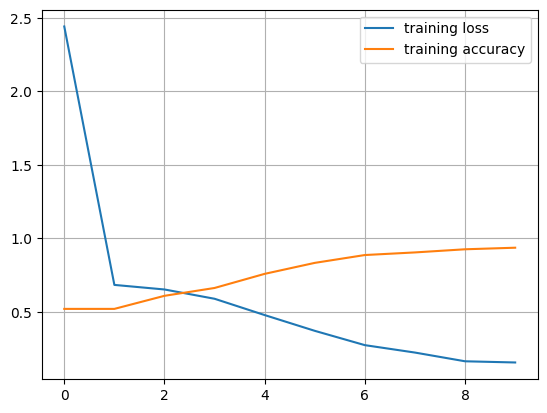

In [31]:
## stats on training data
plt.plot(history.history['loss'], label = 'training loss')
plt.plot(history.history['accuracy'], label = 'training accuracy')
plt.grid(True)
plt.legend()

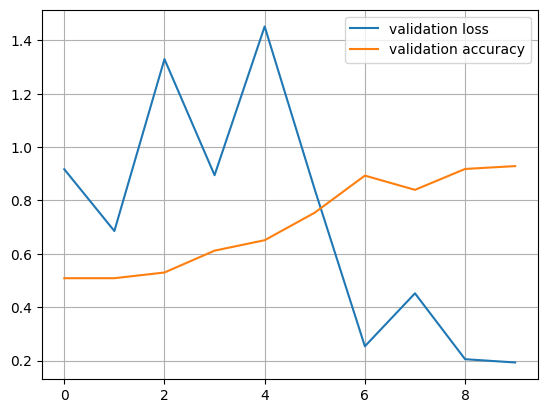

In [32]:
## stats on training data
plt.plot(history.history['val_loss'], label = 'validation loss')
plt.plot(history.history['val_accuracy'], label = 'validation accuracy')
plt.grid(True)
plt.legend()

1/1 [==============================] - 1s 655ms/step


InvalidArgumentError: {{function_node __wrapped__StridedSlice_device_/job:localhost/replica:0/task:0/device:CPU:0}} slice index 30 of dimension 0 out of bounds. [Op:StridedSlice] name: strided_slice/

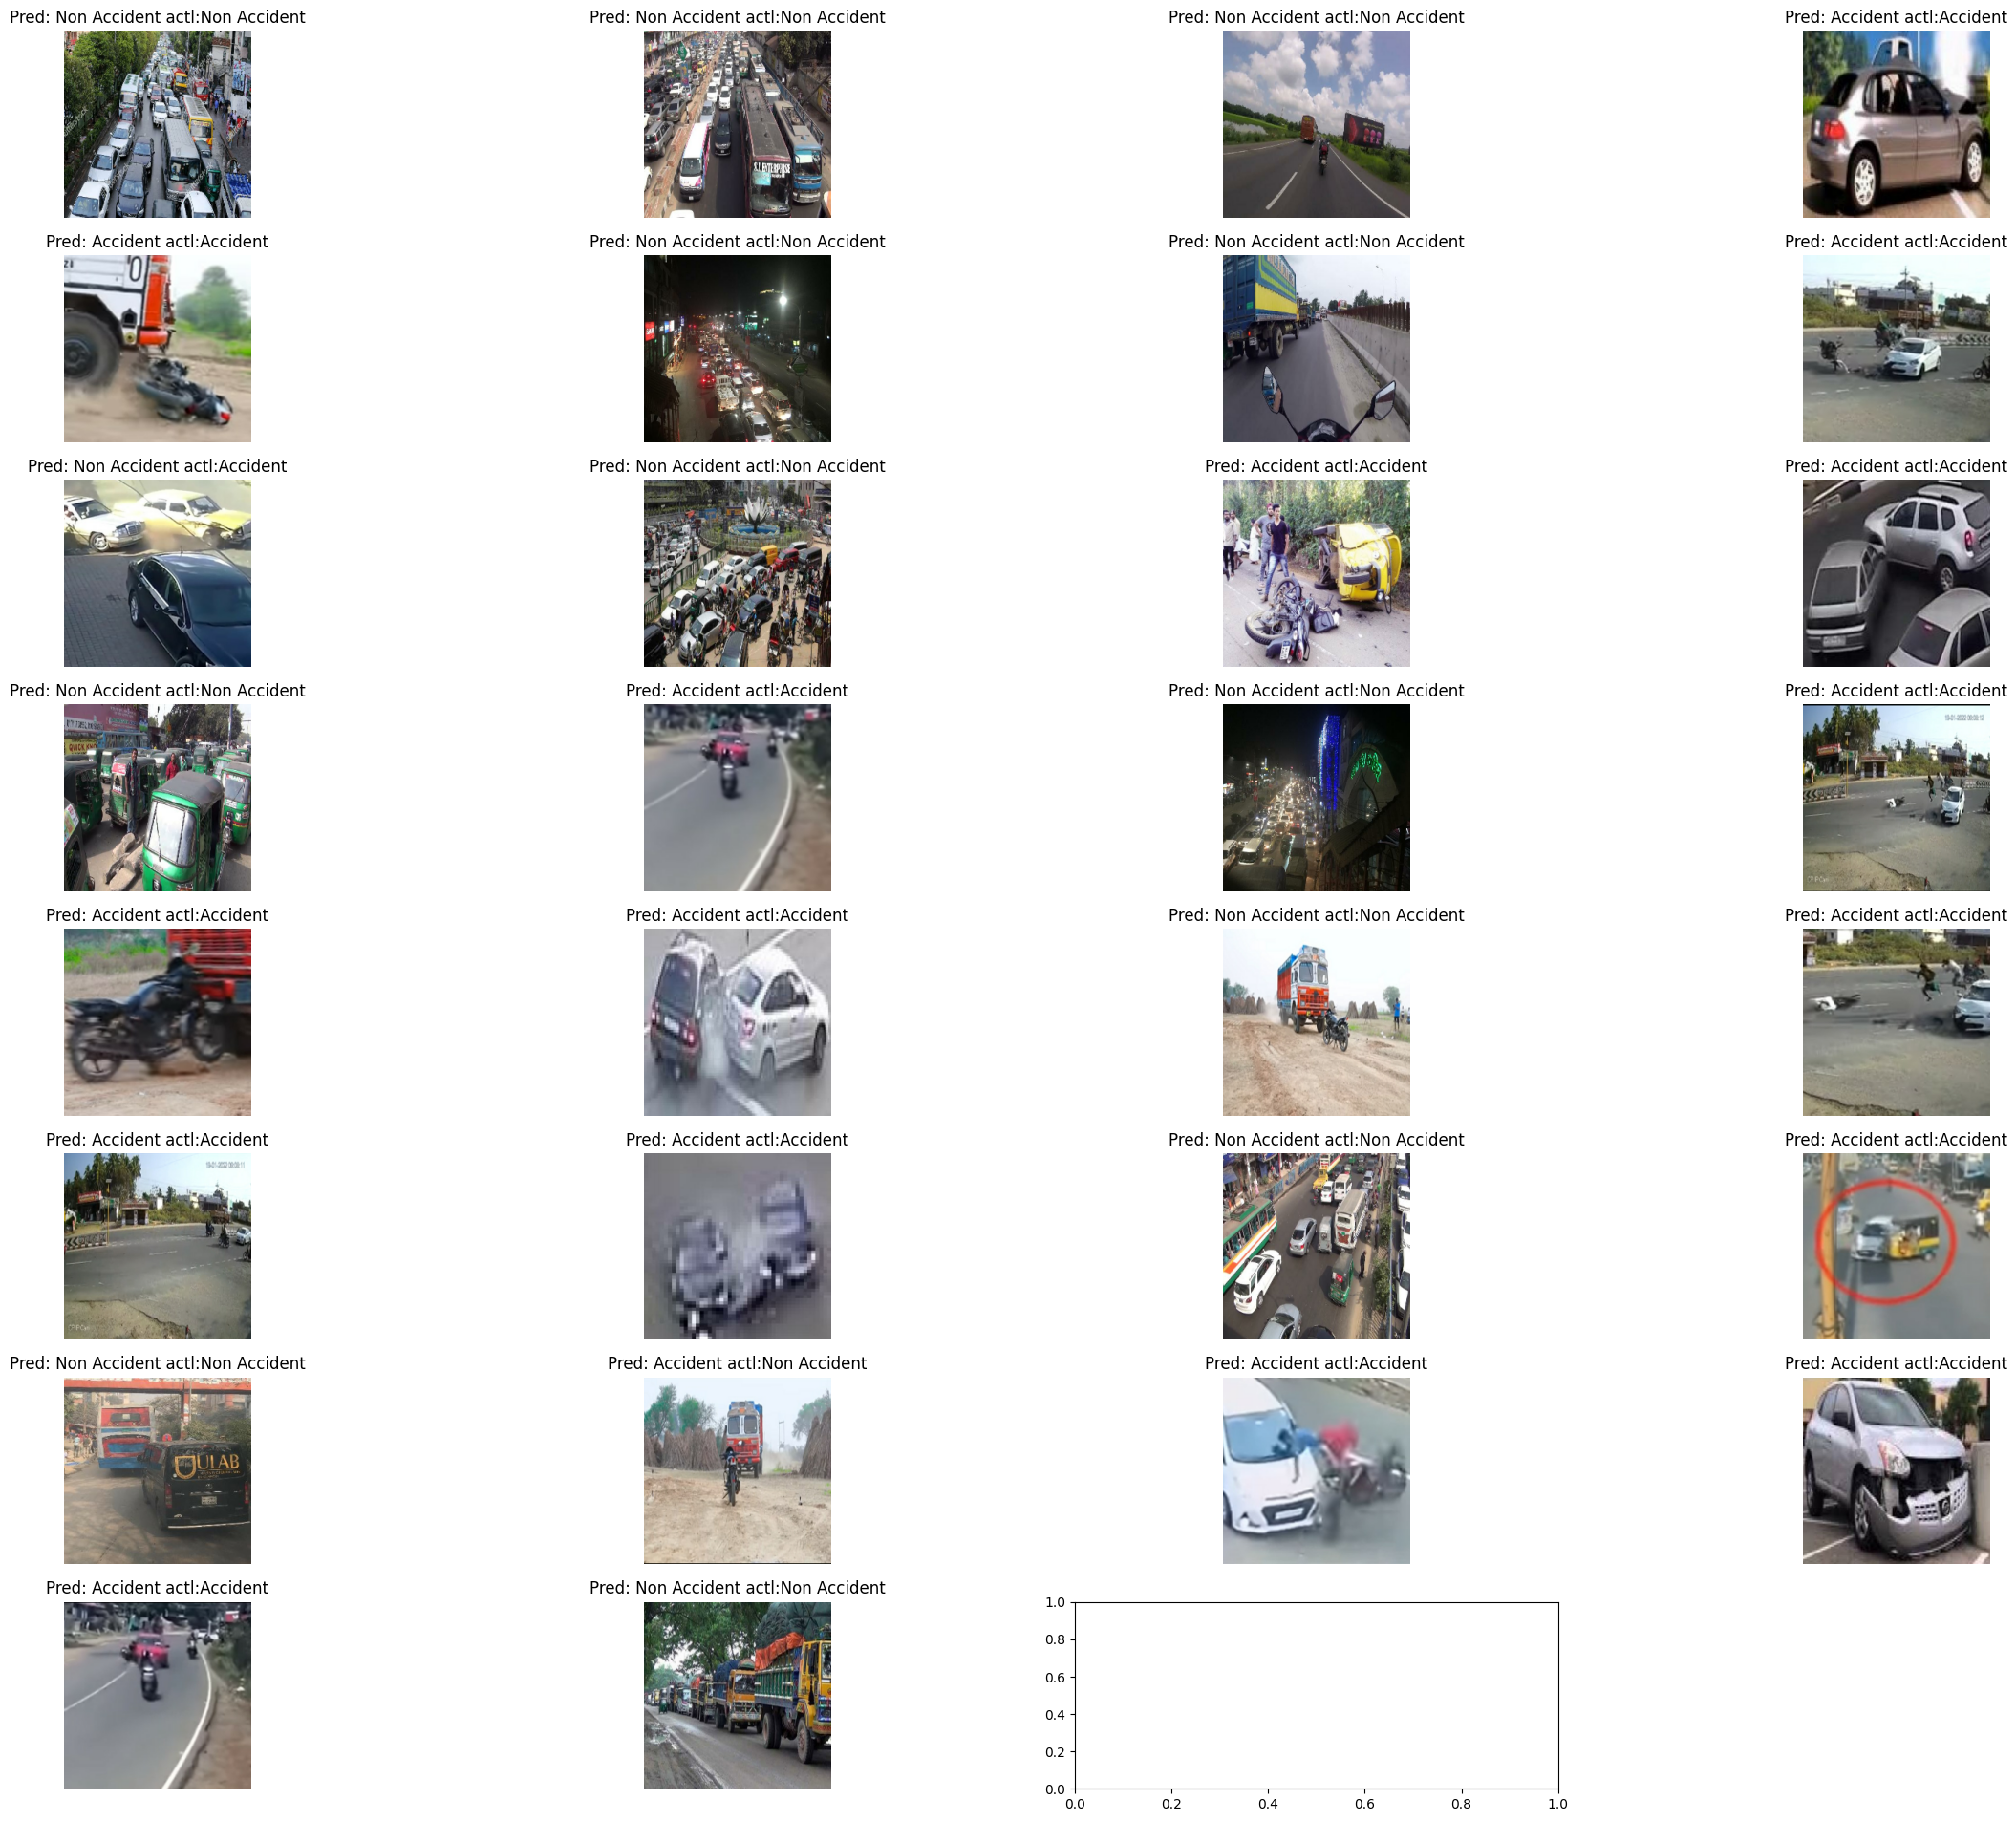

In [33]:
## lets vizualize results on testing data
AccuracyVector = []
plt.figure(figsize=(30, 30))
for images, labels in testing_data.take(1):
    predictions = model.predict(images)
    predlabel = []
    prdlbl = []
    
    for mem in predictions:
        predlabel.append(class_names[np.argmax(mem)])
        prdlbl.append(np.argmax(mem))
    
    AccuracyVector = np.array(prdlbl) == labels
    for i in range(40):
        ax = plt.subplot(10, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title('Pred: '+ predlabel[i]+' actl:'+class_names[labels[i]] )
        plt.axis('off')
        plt.grid(True)